In [1]:
using BSON: @load
using Flux
using Flux: chunk
using Flux.Data: DataLoader
using ImageFiltering
using Images
using ImageIO
using MLDatasets: FashionMNIST
using LinearAlgebra
using MLDatasets
using Plots
using Statistics
using JLD
using Distributions
using FFTW

Consider the denoising problem of recovering $x\in\mathbb{R}^n$ from noisy measurements of the form

$$y = x + \epsilon, $$

where $\epsilon\in\mathbb{R}^n$ is noise. We assume the unknown signal $x$ lives in the range of known generative model $G:\mathbb{R}^k \rightarrow \mathbb{R}^n$, i.e. $x = G(z)$ for some $z \in \mathbb{R}^k$. We assume the generative model $G$ is  fully-connected feedforward network of the form 

$$ G(x) = \sigma_d(A_d\sigma_{d-1}(A_{d-1} \cdots \sigma_1(A_1 z)\cdots)),$$

where $A_i \in \mathbb{R}^{n_i \times n_{i-1}}$ is the weight matrix and $\sigma_i$ is the activation function correpsonding to the $i\text{th}$ layer of $G$. Thus, the task of recovering $x$ can be reduced to recovering the corresponding $z$ such that $G(z) = x$. 


We solve this problem using the following iterative algorithm called Partially Linearized Updates for Generative Inversion (PLUGIn):

$$x^{k+1} = x^k -\eta A_1^{\top}\cdots A_d^{\top}\left(G(x^k) - y \right) .$$

Here, $\eta$ is the stepsize that depends on the weight matrices and the activation functions. This algorithm is implemented below:



We now list the function that are relavant to the computation of the esitmate using the PLUGIn algorithm. The following function can be used to output an estimate $x^{k+1}$ from PLUGIn from another estimate $x^k$ of the ground truth.

In [43]:
# output the plugin Iterate
function PLUGIN_denoise(G, W, y, z, stepsize)
    d = W'* (G(z) - y )
    return z - stepsize * d
end

# output the plugin Iterate
function PLUGIN_denoise_normalized(G, W, y, z, stepsize, scale)
    d = W'* (G(z) - y)
    return (z - stepsize * d) / norm(z - stepsize * d,2)
end

PLUGIN_denoise_normalized (generic function with 2 methods)

One advantage of PLUGIn algorithm in general is that it allows us to pre-multiply the weight matrices. The following function is used to compute $A_d\cdot A_{d-1}\cdots A_1$ given a generative model $G$. It also normalizes each weight matrix w.r.t. its top singular value.

In [3]:
function normalized_weight_product(G)
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /(s[1]^2)
    end
    return W
end  

normalized_weight_product (generic function with 1 method)

In [4]:
function multi_dist(A)
    (m, n) = size(A)
    B = zeros(m,n)
    a = [0,1,-1]
    for i in 1:m
        for j in 1:n
            b = A[i,j]
            for index in 1:3
                if b[index] == 1
                    B[i,j] = a[index]
                end
            end
        end
    end
    return B
end



multi_dist (generic function with 1 method)

The following function can be used to create a general generative function with number of nodes in each layer specified. The entries of the weight matrices are initialized to be normalized random normal.

In [5]:
function create_network(net_param)
    n_0 = net_param[1]
    n_1 = net_param[2]
    L = Chain(Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, relu; initW =(out,in) ->  randn(n_1, n_0)/sqrt(n_1)))
    end
    return L
end


function create_network_bernoulli(net_param, p)
    n_0 = net_param[1]
    n_1 = net_param[2]
    d = -p/(1-p);
    d = -1

    L = Chain(Dense(n_0, n_1, sigmoid; initW =(out,in) -> (2 * rand(Binomial(1, p), n_1, n_0) .- 1)/sqrt(n_1)   )) #((1-d) * rand(Binomial(1, p), n_1, n_0) .+ d)/sqrt(n_1)   ))

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1, sigmoid; initW =(out,in) ->  (2 * rand(Binomial(1, p), n_1, n_0) .- 1)/sqrt(n_1)   )) #((1-d) * rand(Binomial(1, p), n_1, n_0) .+ d)/sqrt(n_1) ))
    end
    return L
end

function create_network_multi(net_param, p)
    n_0 = net_param[1]
    n_1 = net_param[2]
    # d = -p/(1-p);
    # d = -1
    L = Chain(Dense(n_0, n_1, 2*sigmoid .- 1; initW =(out,in) -> multi_dist(rand(Multinomial(1, p), n_1, n_0))/sqrt(n_1)   )) 

    for i in 2:length(net_param)-1
        n_0 = net_param[i]
        n_1 = net_param[i+1]
        L = Chain(L, Dense(n_0, n_1,  2*sigmoid .- 1; initW =(out,in) ->  multi_dist(rand(Multinomial(1, p), n_1, n_0))/sqrt(n_1)   )) 
    end
    return L
end



function relative_error(x̂,x̃)
    return norm(x̃ - x̂, 2)/norm(x̂, 2)
end


relative_error (generic function with 1 method)

In [6]:

function PLUGIn_denoise(G,y, max_iter, stepsize, tolerance, out_toggle)
    
    (_, z_dim) = size(Flux.params(G[1])[1]);
    W = I(z_dim)
  
    #normalize the weights of the network
    for i in 1:length(G)
        _, s, _ = svd(Flux.params(G[i])[1])
        W = Flux.params(G[i])[1] * W /s[1]
    end
  
    z = randn(z_dim)
    iter = 1
    succ_error = 1
  
    while iter <= max_iter && succ_error > tolerance
      
      # d gives the PLUGIn direction
      d = W'*(G(z) - y)
      z -= stepsize * d
      succ_error = norm(stepsize * d)
      if iter % out_toggle == 0  
          println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
      end
      iter += 1
    end
    println("====> In quasi-gradient: Iteration: $iter Successive error: $succ_error")
  
    return z
  end

PLUGIn_denoise (generic function with 1 method)

In the next code segment, we examine the relationship between recovery and reconstruction with respect to iteration. In particular, we are interested in seeing if the PLUGIn algorith benefits from early stopping by not overfitting to the noise in the measurement. 

In [7]:
function overfit_plot(G, noise_level)
    depth = length(Flux.params(G))/2

    (_, z_dim) = size(Flux.params(G)[1]);
    (x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
    stepsize = .1
    max_iter = 100
    # tolerance = 1e-4
    W = normalized_weight_product(G)
    trials = 2

    recov_error_matrix = zeros(max_iter, 1)
    recon_error_matrix = zeros(max_iter, 1)

    for trial in 1:trials
        recov_error = []
        recon_error = []
        z = randn(z_dim)
        noise = randn(x_dim)
        noise =  noise_level * noise * norm(G(z))/norm(noise) 
        y = G(z) + noise
        z_est = zeros(z_dim)
        iter = 1
        succ_error = 1

        for iter in 1:max_iter
            z_old = z_est
            z_est = PLUGIN_denoise(G, W, y, z_est, stepsize)
            succ_error = norm(z_old - z_est, 2)

            push!( recon_error, norm(G(z) - G(z_est))/norm(G(z)) )
            push!( recov_error, norm(z - z_est)/norm(z_est) )

        end
        recov_error_matrix = hcat(recov_error_matrix, recov_error)
        recon_error_matrix = hcat(recon_error_matrix, recon_error)
    end

    # change the filenames if you wish to save the results
    # save("result/error_denoise_recov.jld", "error", recov_error_matrix[:,2:end], "iterations", iterations)
    # save("result/error_denoise_recon.jld", "error", recon_error_matrix[:,2:end], "iterations", 1:max_iter)

    average_recov = mean(recov_error_matrix[:,2:end], dims=2)
    std_recov = std(recov_error_matrix[:,2:end], dims=2)
    plot(1:max_iter, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
    p1 = plot!(1:max_iter, average_recov, label = "recovery error")

    average_recon = mean(recon_error_matrix[:,2:end], dims=2)
    std_recon = std(recon_error_matrix[:,2:end], dims=2)
    plot(1:max_iter, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 1, label = false)
    p2 = plot!(1:max_iter, average_recon, label = "reconstruction error")
    return p1, p2 
end

overfit_plot (generic function with 1 method)

In [50]:
function SNR(G)
    depth = length(Flux.params(G))/2

    (_, z_dim) = size(Flux.params(G)[1]);
    (x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
    W = normalized_weight_product(G)

    max_iter = 1000
    stepsize = .5

    noise_level_list = 0:.1:1
    trials = 4

    recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
    recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

    recov_error_matrix_PLUGIn_norm = zeros(length(noise_level_list))
    recon_error_matrix_PLUGIn_norm = zeros(length(noise_level_list))

    recov_error_matrix_GD = zeros(length(noise_level_list))
    recon_error_matrix_GD = zeros(length(noise_level_list))

    for trial in 1:trials

        recov_error_PLUGIn = []
        recon_error_PLUGIn = []

        recov_error_PLUGIn_norm = []
        recon_error_PLUGIn_norm = []

        recov_error_GD = []
        recon_error_GD = []

        z = randn(z_dim)
        scale = 16
        z = scale*z/norm(z)
        
        for noise_level in noise_level_list
            y = G(z) + noise_level * randn(x_dim)
            descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]        

            z_est_PLUGIn = randn(z_dim)
            z_est_PLUGIn_norm = randn(z_dim)
            z_est_GD = randn(z_dim)
            iter = 1
            for iter in 1:max_iter
                z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize)
                if iter < floor(max_iter*1)
                    z_est_PLUGIn_norm = PLUGIN_denoise_normalized(G, W, y, z_est_PLUGIn_norm, stepsize, scale)
                else
                    z_est_PLUGIn_norm = PLUGIN_denoise(G, W, y, z_est_PLUGIn_norm, stepsize)
                end
                d = descent(z_est_GD); z_est_GD -= stepsize *d
            end

            push!(recov_error_PLUGIn, norm(z - z_est_PLUGIn))#relative_error(z, z_est_PLUGIn))
            push!(recon_error_PLUGIn,  norm(G(z) - G(z_est_PLUGIn)))#relative_error(G(z), G(z_est_PLUGIn)) )

            push!(recov_error_PLUGIn_norm,  norm(z - z_est_PLUGIn_norm))#relative_error(z, z_est_PLUGIn_norm))
            push!(recon_error_PLUGIn_norm,  norm(G(z) - G(z_est_PLUGIn_norm)))#relative_error(G(z), G(z_est_PLUGIn_norm)) )

            push!(recov_error_GD,  norm(z - z_est_GD))#relative_error(z, z_est_GD))
            push!(recon_error_GD,  norm(G(z) - G(z_est_GD)))#relative_error(G(z), G(z_est_GD)) )  

        end

        recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
        recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

        recov_error_matrix_PLUGIn_norm = hcat(recov_error_matrix_PLUGIn_norm, recov_error_PLUGIn_norm)
        recon_error_matrix_PLUGIn_norm =  hcat(recon_error_matrix_PLUGIn_norm, recon_error_PLUGIn_norm)

        recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
        recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

        println("Done with trial $trial")

    end

    average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
    plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false)
    plot!(noise_level_list, average_recov, label = "PLUGIn", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:black)
    
    average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
    plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 2, label = false)
    plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:red)
    

    average_recov = mean(recov_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    std_recov = std(recov_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.75, c = 9, label = false)
    p1 = plot!(noise_level_list, average_recov, label = "PLUGIn normalized", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:yellow)
    
    
    average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
    plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.5, c = 0, label = false)
    plot!(noise_level_list, average_recon, label = "PLUGIn", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:black)
    

    average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
    plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 2, label = false)
    plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)
    
    average_recon = mean(recon_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    std_recon = std(recon_error_matrix_PLUGIn_norm[:, 2:end], dims=2)
    plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.75, c = 9, label = false)
    p2 = plot!(noise_level_list, average_recon, label = "PLUGIn normalized", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:yellow)
    

    return p1, p2

    
end


SNR (generic function with 1 method)

In [48]:
function compression_ratio(G)
    depth = length(Flux.params(G))/2

    (_, z_dim) = size(Flux.params(G)[1]);
    (x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
    W = normalized_weight_product(G)

    max_iter = 1000
    stepsize = 1
    trials = 10

    recov_error_PLUGIn = []
    recon_error_PLUGIn = []

    recov_error_GD = []
    recon_error_GD = []

    for trial in 1:trials

        z = randn(z_dim)
        noise = randn(x_dim)
        y = G(z) + noise/norm(noise)
        descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]        

        z_est_PLUGIn = randn(z_dim)
        z_est_GD = randn(z_dim)
        iter = 1
        for iter in 1:max_iter
            z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize)
            d = descent(z_est_GD); z_est_GD -= stepsize *d
        end

        push!(recov_error_PLUGIn, relative_error(z, z_est_PLUGIn))
        push!(recon_error_PLUGIn, relative_error(G(z), G(z_est_PLUGIn)) )

        push!(recov_error_GD, relative_error(z, z_est_GD))
        push!(recon_error_GD, relative_error(G(z), G(z_est_GD)) )  

    end

    return recov_error_PLUGIn, recon_error_PLUGIn, recov_error_GD, recon_error_GD    
end


compression_ratio (generic function with 1 method)

Done with trial 1
Done with trial 2
Done with trial 3
Done with trial 4


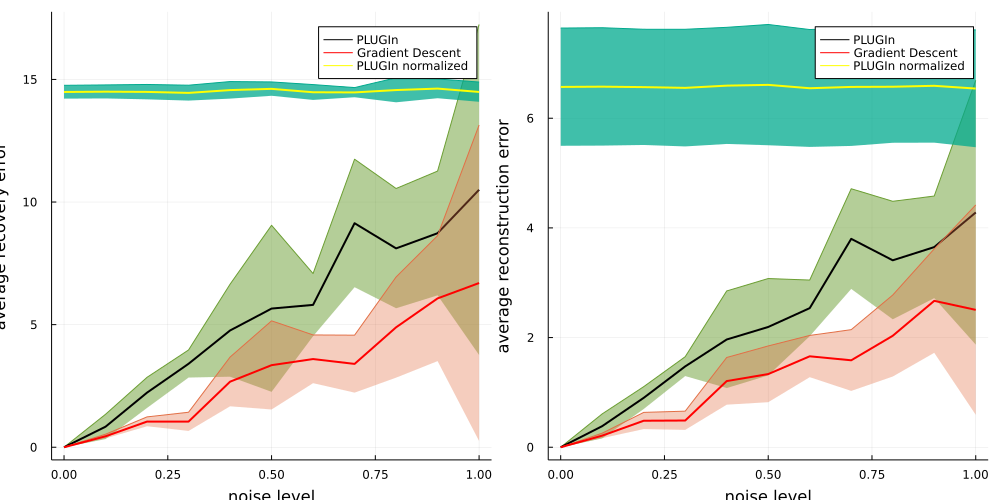

In [51]:
#########  SNR  #################
net_param = [5, 200, 750]
G = create_network(net_param)
W = normalized_weight_product(G)
#######
p3, p4 = SNR(G)
######### overfit ##############
# p5, p6 = overfit_plot(G, .5)


gr(size = (1000,500))
# plot(p1,p2,p3,p4,p5,p6, layout = (3,2))
plot(p3,p4, layout = (1,2))

In [15]:
########## Bernoulli ################

# x_dim_list = 200:100:1000
# p = .5
# net_param = [20, x_dim_list[1], x_dim_list[1]]
# G = create_network_bernoulli(net_param, p)
# W = normalized_weight_product(G)
# recov_error_PLUGIn, recon_error_PLUGIn, recov_error_GD, recon_error_GD = compression_ratio(G)
# recov_error_PLUGIn, recon_error_PLUGIn, recov_error_GD, recon_error_GD = recov_error_PLUGIn', recon_error_PLUGIn', recov_error_GD', recon_error_GD'

# for i in 2:length(x_dim_list)
#     x_dim = x_dim_list[i]
#     net_param = [20, x_dim, x_dim]
#     G = create_network(net_param)
#     W = normalized_weight_product(G)
#     recov_error_PLUGIn_m, recon_error_PLUGIn_m, recov_error_GD_m, recon_error_GD_m = compression_ratio(G)

#     recov_error_PLUGIn = vcat(recov_error_PLUGIn,recov_error_PLUGIn_m')
#     recon_error_PLUGIn = vcat(recon_error_PLUGIn,recon_error_PLUGIn_m')

#     recov_error_GD =  vcat(recov_error_GD,recov_error_GD_m')
#     recon_error_GD = vcat(recon_error_GD,recon_error_GD_m')
# end
# average_recov = mean(recov_error_PLUGIn, dims=2)
# std_recov = std(recov_error_PLUGIn, dims=2)
# plot(x_dim_list/z_dim, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false,xaxis=:log, yaxis=:log)
# plot!(x_dim_list/z_dim, average_recov, label = "PLUGIn", xlabel = "Expansion ratio, \$n_d/n_0\$", ylabel = "average recovery error", linewidth = 2, c =:black,xaxis=:log, yaxis=:log)

# average_recov = mean(recov_error_GD, dims=2)
# std_recov = std(recov_error_GD, dims=2)
# plot!(x_dim_list/z_dim, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 2, label = false,xaxis=:log, yaxis=:log)
# p1 = plot!(x_dim_list/z_dim, average_recov, label = "Gradient Descent", xlabel = "Expansion ratio, \$n_d/n_0\$", ylabel = "average recovery error", linewidth = 2, c =:red,xaxis=:log, yaxis=:log)


# average_recon = mean(recon_error_PLUGIn, dims=2)
# std_recon = std(recon_error_PLUGIn, dims=2)
# plot(x_dim_list/z_dim, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.5, c = 0, label = false,xaxis=:log, yaxis=:log)
# plot!(x_dim_list/z_dim, average_recon, label = "PLUGIn", xlabel = "Expansion ratio, \$n_d/n_0\$", ylabel = "average reconstruction error", linewidth = 2 , c =:black,xaxis=:log, yaxis=:log)

# average_recon = mean(recon_error_GD, dims=2)
# std_recon = std(recon_error_GD, dims=2)
# plot!(x_dim_list/z_dim, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 2, label = false,xaxis=:log, yaxis=:log)
# p2 = plot!(x_dim_list/z_dim, average_recon, label = "Gradient Descent", xlabel = "Expansion ratio, \$n_d/n_0\$", ylabel = "average reconstruction error", linewidth = 2, c =:red,xaxis=:log, yaxis=:log)

#########  SNR  #################
net_param = [5, 200, 750]
p = .2
G = create_network_bernoulli(net_param, p)
W = normalized_weight_product(G)

# p3, p4 = SNR(G)
# ######### overfit ##############
p5, p6 = overfit_plot(G)

# gr(size = (1000,500))
# plot(p1,p2,p3,p4,p5,p6, layout = (3,2))


(Plot{Plots.GRBackend() n=2}, Plot{Plots.GRBackend() n=2})

In [10]:
function sigmoid_bern(p)
    net_param = [5, 700, 1000]
    G = create_network_bernoulli(net_param, p)
    W = normalized_weight_product(G)


    depth = length(Flux.params(G))/2

    (_, z_dim) = size(Flux.params(G)[1]);
    (x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
    stepsize = .5
    stepsize_GD = 5
    max_iter = 2000
    # tolerance = 1e-4
    W = normalized_weight_product(G)
    trials = 2

    recov_error_matrix = zeros(max_iter, 1)
    recon_error_matrix = zeros(max_iter, 1)

    recov_error_matrix_GD = zeros(max_iter, 1)
    recon_error_matrix_GD = zeros(max_iter, 1)

    for trial in 1:trials
        recov_error = []
        recon_error = []

        recov_error_GD = []
        recon_error_GD = []

        z = randn(z_dim)
        noise = randn(x_dim)
        noise =  .0*noise * norm(G(z))/norm(noise) 
        y = G(z) + noise
        z_est = zeros(z_dim)
        z_est_GD = randn(z_dim)
        iter = 1
        succ_error = 1

        descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]        

        for iter in 1:max_iter
            z_old = z_est
            z_old_GD = z_est_GD
            d = descent(z_est_GD); z_est_GD -= stepsize_GD *d
            z_est = PLUGIN_denoise(G, W, y, z_est, stepsize)
            succ_error = norm(z_old - z_est, 2)
            succ_error = norm(z_old_GD - z_est_GD)

            push!( recon_error, norm(G(z) - G(z_est))/norm(G(z)) )
            push!( recov_error, norm(z - z_est)/norm(z) )

            push!( recon_error_GD, norm(G(z) - G(z_est_GD))/norm(G(z)) )
            push!( recov_error_GD, norm(z - z_est_GD)/norm(z) )

        end
        recov_error_matrix = hcat(recov_error_matrix, recov_error)
        recon_error_matrix = hcat(recon_error_matrix, recon_error)

        recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
        recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD) 
    end

    average_recov = mean(recov_error_matrix[:,2:end], dims=2)
    std_recov = std(recov_error_matrix[:,2:end], dims=2)
    plot(1:max_iter, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
    plot!(1:max_iter, average_recov, label = "recovery error PLUGIN", c=:red)

    average_recov_GD = mean(recov_error_matrix_GD[:,2:end], dims=2)
    std_recov_GD = std(recov_error_matrix_GD[:,2:end], dims=2)
    plot!(1:max_iter, average_recov_GD + std_recov_GD, fillrange = average_recov_GD - std_recov_GD,fillalpha = 0.35, c = 1, label = false)
    p1 = plot!(1:max_iter, average_recov_GD, label = "recovery error GD", c =:black)

    return p1
end

sigmoid_bern (generic function with 1 method)

In [11]:
p1 = sigmoid_bern(.1)
p3 = sigmoid_bern(.3)
p5 = sigmoid_bern(.5)
p7 = sigmoid_bern(.7)
p9 = sigmoid_bern(.9);



Loading model...Done
4109.2466
Done with trial 1
Done with trial 2


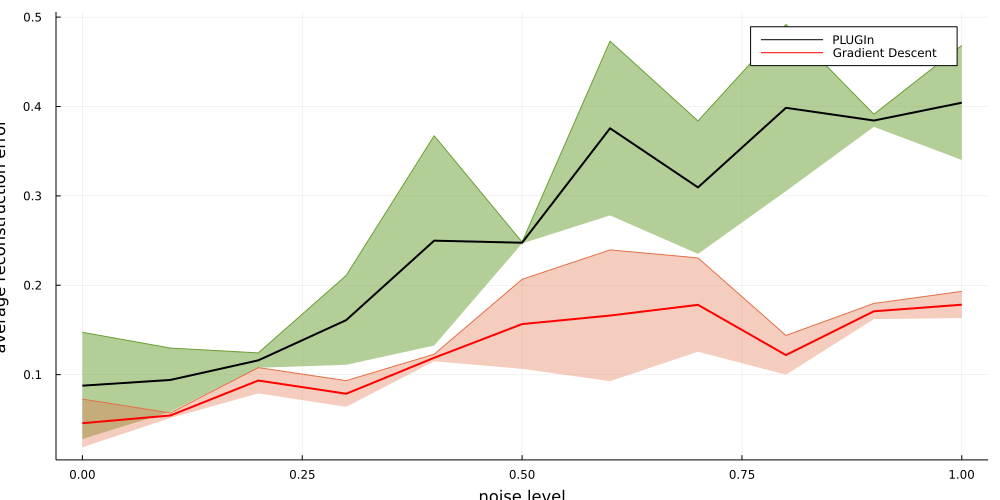

In [34]:
# experiments with MNIST dataset
function load_model(load_dir::String, epoch::Int)
    print("Loading model...")
    @load joinpath(load_dir, "model-$epoch.bson") encoder_μ encoder_logvar decoder
    println("Done")
    return encoder_μ, encoder_logvar, decoder
end

function get_train_loader(batch_size, shuffle::Bool)
    # The MNIST training set is made up of 60k 28 by 28 greyscale images
    train_x, train_y = MNIST.traindata(Float32)
    train_x = 1 .- reshape(train_x, (784, :))
    return DataLoader((train_x, train_y), batchsize=batch_size, shuffle=shuffle, partial=false)
end

epoch_to_load = 20
# Load the model and test set loader
encoder_mu, encoder_logvar, decoder = load_model("result/MNIST", epoch_to_load)

G = Chain(decoder[1],decoder[2])


#####################################

depth = length(Flux.params(G))/2

(_, z_dim) = size(Flux.params(G)[1]);
(x_dim, _ ) = size(Flux.params(G)[Int(depth*2 - 1)])
W = normalized_weight_product(G)

max_iter = 1000
s = 1
for i in 1:length(G)
    _, s2, _ = svd(Flux.params(G[i])[1])
    s = s2[1]^2*s
end

println(s)

stepsize = 1
stepsize_GD = 1/s

noise_level_list = 0:.1:1
trials = 2

recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

recov_error_matrix_GD = zeros(length(noise_level_list))
recon_error_matrix_GD = zeros(length(noise_level_list))

for trial in 1:trials

    recov_error_PLUGIn = []
    recon_error_PLUGIn = []

    recov_error_GD = []
    recon_error_GD = []

    z = randn(z_dim)
    
    for noise_level in noise_level_list
        y = G(z) + noise_level * randn(x_dim)
        descent(z) = gradient(z->norm(G(z) - y,2)^2, z)[1]        

        z_est_PLUGIn = randn(z_dim)
        z_est_GD = randn(z_dim)
        iter = 1
        for iter in 1:max_iter
            z_est_PLUGIn = PLUGIN_denoise(G, W, y, z_est_PLUGIn, stepsize)
            d = descent(z_est_GD); z_est_GD -= stepsize_GD *d
        end

        push!(recov_error_PLUGIn, relative_error(z, z_est_PLUGIn))
        push!(recon_error_PLUGIn, relative_error(G(z), G(z_est_PLUGIn)) )

        push!(recov_error_GD, relative_error(z, z_est_GD))
        push!(recon_error_GD, relative_error(G(z), G(z_est_GD)) )  

    end

    recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
    recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

    recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
    recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

    println("Done with trial $trial")

end

average_recov = mean(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_PLUGIn[:, 2:end], dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false)
plot!(noise_level_list, average_recov, label = "PLUGIn", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:black)

average_recov = mean(recov_error_matrix_GD[:, 2:end], dims=2)
std_recov = std(recov_error_matrix_GD[:, 2:end], dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 2, label = false)
p1 = plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_PLUGIn[:, 2:end], dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.5, c = 0, label = false)
plot!(noise_level_list, average_recon, label = "PLUGIn", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:black)

average_recon = mean(recon_error_matrix_GD[:, 2:end], dims=2)
std_recon = std(recon_error_matrix_GD[:, 2:end], dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 2, label = false)
p2 = plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)



# #######
# p3, p4 = SNR(G)
# ######### overfit ##############
# p5, p6 = overfit_plot(G, .5)

# gr(size = (1000,500))
# plot(p3,p4,p5,p6, layout = (2,2))


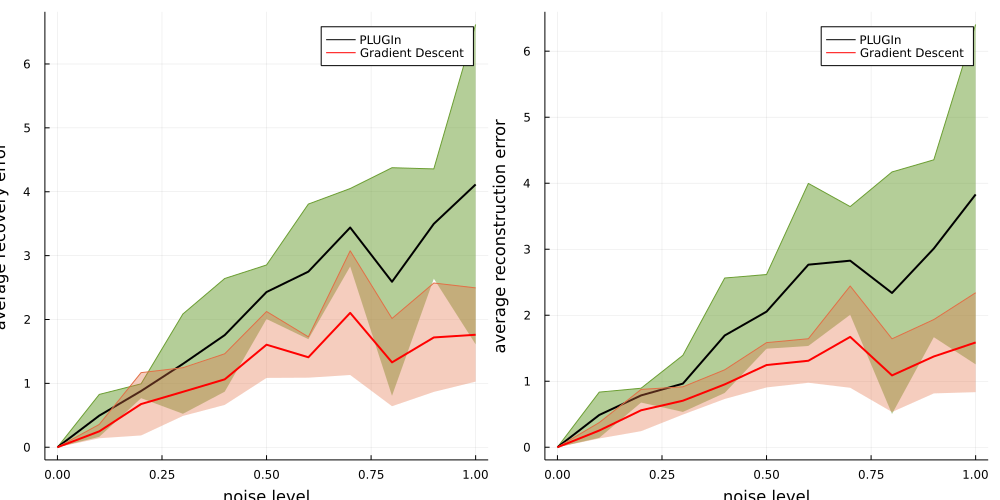

In [36]:
plot(p3,p4, layout = (1,2))

In [23]:
recon_error_matrix_GD[:, 2:end]

11×2 Matrix{Any}:
 NaN  NaN
 NaN  NaN
 NaN  NaN
 NaN  NaN
 NaN  NaN
 NaN  NaN
 NaN  NaN
 NaN  NaN
 NaN  NaN
 NaN  NaN
 NaN  NaN

In [116]:
# ########### Random weights #####################

# x_dim_list = 200:100:1000

# net_param = [20, x_dim_list[1], x_dim_list[1]]
# p = [.8,.1,.1]
# G = create_network_multi(net_param, p)
# W = normalized_weight_product(G)
# recov_error_PLUGIn, recon_error_PLUGIn, recov_error_GD, recon_error_GD = compression_ratio(G)
# recov_error_PLUGIn, recon_error_PLUGIn, recov_error_GD, recon_error_GD = recov_error_PLUGIn', recon_error_PLUGIn', recov_error_GD', recon_error_GD'

# for i in 2:length(x_dim_list)
#     x_dim = x_dim_list[i]
#     net_param = [20, x_dim, x_dim]
#     G = create_network(net_param)
#     W = normalized_weight_product(G)
#     recov_error_PLUGIn_m, recon_error_PLUGIn_m, recov_error_GD_m, recon_error_GD_m = compression_ratio(G)

#     recov_error_PLUGIn = vcat(recov_error_PLUGIn,recov_error_PLUGIn_m')
#     recon_error_PLUGIn = vcat(recon_error_PLUGIn,recon_error_PLUGIn_m')

#     recov_error_GD =  vcat(recov_error_GD,recov_error_GD_m')
#     recon_error_GD = vcat(recon_error_GD,recon_error_GD_m')
# end
# average_recov = mean(recov_error_PLUGIn, dims=2)
# std_recov = std(recov_error_PLUGIn, dims=2)
# plot(x_dim_list/z_dim, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false,xaxis=:log, yaxis=:log)
# plot!(x_dim_list/z_dim, average_recov, label = "PLUGIn", xlabel = "Expansion ratio, \$n_d/n_0\$", ylabel = "average recovery error", linewidth = 2, c =:black,xaxis=:log, yaxis=:log)

# average_recov = mean(recov_error_GD, dims=2)
# std_recov = std(recov_error_GD, dims=2)
# plot!(x_dim_list/z_dim, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 2, label = false,xaxis=:log, yaxis=:log)
# p1 = plot!(x_dim_list/z_dim, average_recov, label = "Gradient Descent", xlabel = "Expansion ratio, \$n_d/n_0\$", ylabel = "average recovery error", linewidth = 2, c =:red,xaxis=:log, yaxis=:log)


# average_recon = mean(recon_error_PLUGIn, dims=2)
# std_recon = std(recon_error_PLUGIn, dims=2)
# plot(x_dim_list/z_dim, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.5, c = 0, label = false,xaxis=:log, yaxis=:log)
# plot!(x_dim_list/z_dim, average_recon, label = "PLUGIn", xlabel = "Expansion ratio, \$n_d/n_0\$", ylabel = "average reconstruction error", linewidth = 2 , c =:black,xaxis=:log, yaxis=:log)

# average_recon = mean(recon_error_GD, dims=2)
# std_recon = std(recon_error_GD, dims=2)
# plot!(x_dim_list/z_dim, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 2, label = false,xaxis=:log, yaxis=:log)
# p2 = plot!(x_dim_list/z_dim, average_recon, label = "Gradient Descent", xlabel = "Expansion ratio, \$n_d/n_0\$", ylabel = "average reconstruction error", linewidth = 2, c =:red,xaxis=:log, yaxis=:log)

#########  SNR  #################
net_param = [5, 200, 750]
p = [.6,.3,.1]
G = create_network_multi(net_param, p)
W = normalized_weight_product(G)
#######
p3, p4 = SNR(G)
######### overfit ##############
p5, p6 = overfit_plot(G, .1)

gr(size = (1000,500))
plot(p3,p4,p5,p6, layout = (2,2))

LoadError: MethodError: no method matching *(::Int64, ::typeof(σ))
[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/operators.jl:655
[0m  *(::T, [91m::T[39m) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/int.jl:88
[0m  *(::Union{Int16, Int32, Int64, Int8}, [91m::BigInt[39m) at /Applications/Julia-1.7.app/Contents/Resources/julia/share/julia/base/gmp.jl:542
[0m  ...

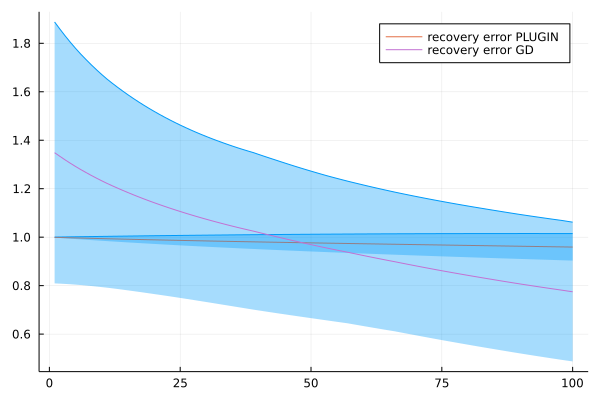

In [39]:

# change the filenames if you wish to save the results
# save("result/error_denoise_recov.jld", "error", recov_error_matrix[:,2:end], "iterations", iterations)
# save("result/error_denoise_recon.jld", "error", recon_error_matrix[:,2:end], "iterations", 1:max_iter)



average_recov = mean(recov_error_matrix[:,2:end], dims=2)
std_recov = std(recov_error_matrix[:,2:end], dims=2)
plot(1:max_iter, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
plot!(1:max_iter, average_recov, label = "recovery error PLUGIN")

average_recov_GD = mean(recov_error_matrix_GD[:,2:end], dims=2)
std_recov_GD = std(recov_error_matrix_GD[:,2:end], dims=2)
plot!(1:max_iter, average_recov_GD + std_recov_GD, fillrange = average_recov_GD - std_recov_GD,fillalpha = 0.35, c = 1, label = false)
p1 = plot!(1:max_iter, average_recov_GD, label = "recovery error GD")

# average_recon = mean(recon_error_matrix[:,2:end], dims=2)
# std_recon = std(recon_error_matrix[:,2:end], dims=2)
# plot(1:max_iter, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 1, label = false)
# p2 = plot!(1:max_iter, average_recon, label = "reconstruction error")


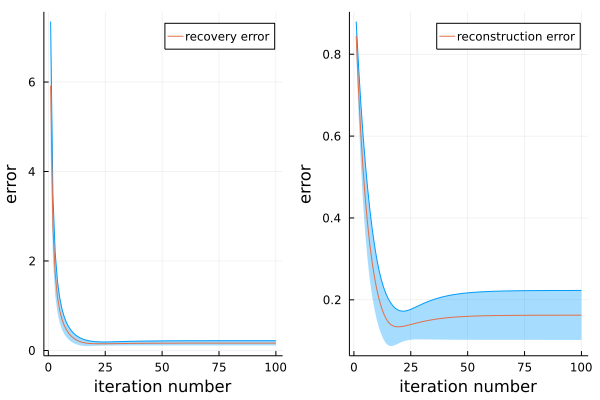

In [31]:
M_recon = load("result/error_denoise_recon.jld", "error")
M_recov = load("result/error_denoise_recov.jld", "error")
iterations = load("result/error_denoise_recov.jld", "iterations")

average_recov = mean(M_recov, dims=2)
std_recov = std(M_recov, dims=2)
plot(iterations, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 1, label = false)
p1 = plot!(iterations, average_recov, label = "recovery error")

average_recon = mean(M_recon, dims=2)
std_recon = std(M_recon, dims=2)
plot(iterations, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 1, label = false)
p2 = plot!(iterations, average_recon, label = "reconstruction error")



plot(p1, p2,layout = 2, xlabel = "iteration number", ylabel = "error")


In the following we use a pre-trained network $G:\mathbb{R}^k\rightarrow \mathbb{R}^n$ to compare preformance of PLUGIn and Gradient descent on noisy data. We pick a random latent code $z$ and attempt to recover $z$ from noisy measurements of the form

$$ y = G(z) + \epsilon,$$

where $\|\epsilon\|$ is approximately in the range $[0, \sqrt{n}]$

In [12]:


z = randn(20)
W = normalized_weight_product(decoder)


max_iter = 1000
stepsize = 1

noise_level_list = 0:.1:1
trials = 10

recov_error_matrix_PLUGIn = zeros(length(noise_level_list))
recon_error_matrix_PLUGIn = zeros(length(noise_level_list))

recov_error_matrix_GD = zeros(length(noise_level_list))
recon_error_matrix_GD = zeros(length(noise_level_list))

for trail in 1:trials


    recov_error_PLUGIn = []
    recon_error_PLUGIn = []

    recov_error_GD = []
    recon_error_GD = []


    for noise_level in noise_level_list
        y = decoder(z) + noise_level *randn(784)
        descent(z) = gradient(z->norm(decoder(z) - y,2)^2, z)[1]        

        z_est_PLUGIn = randn(20)
        z_est_GD = randn(20)
        iter = 1
        for iter in 1:max_iter
            z_est_PLUGIn = PLUGIN_denoise(decoder, W, y, z_est_PLUGIn, stepsize)
            d = descent(z_est_GD); z_est_GD -= stepsize *d
        end

        push!(recov_error_PLUGIn, relative_error(z, z_est_PLUGIn))
        push!(recon_error_PLUGIn, relative_error(decoder(z), decoder(z_est_PLUGIn)) )

        push!(recov_error_GD, relative_error(z, z_est_GD))
        push!(recon_error_GD, relative_error(decoder(z), decoder(z_est_GD)) )  

    end

    recov_error_matrix_PLUGIn = hcat(recov_error_matrix_PLUGIn, recov_error_PLUGIn)
    recon_error_matrix_PLUGIn =  hcat(recon_error_matrix_PLUGIn, recon_error_PLUGIn)

    recov_error_matrix_GD = hcat(recov_error_matrix_GD, recov_error_GD)
    recon_error_matrix_GD = hcat(recon_error_matrix_GD, recon_error_GD)

end


Loading model...Done


In [13]:
# change the filename before running this code if you wish to save the results

save("result/recov_error_PLUGIn.jld", "error", recov_error_matrix_PLUGIn[:,2:end], "noise level list", noise_level_list, "trials", trials)
save("result/recon_error_PLUGIn.jld", "error", recon_error_matrix_PLUGIn[:,2:end], "noise level list", noise_level_list, "trials", trials)


save("result/recov_error_GD.jld", "error", recov_error_matrix_GD[:,2:end], "noise level list", noise_level_list, "trials", trials)
save("result/recon_error_GD.jld", "error", recon_error_matrix_GD[:,2:end], "noise level list", noise_level_list, "trials", trials)



Below we show the plot of results of an instance of the above code segment. Interesting, PLUGIN performs better than Gradient Descent for small noise?

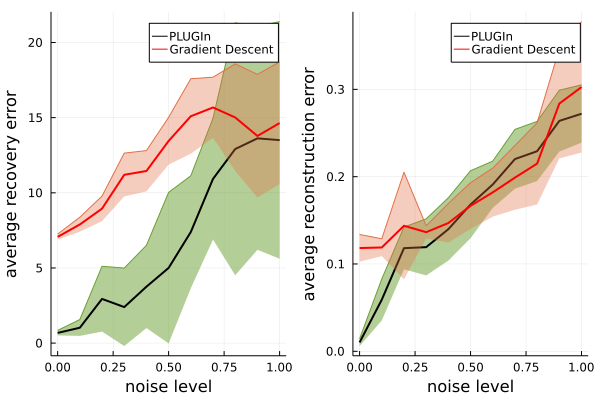

In [5]:
noise_level_list =  load("result/recov_error_PLUGIn.jld", "noise level list")
recov_error_matrix_PLUGIn_loaded = load("result/recov_error_PLUGIn.jld", "error")
recon_error_matrix_PLUGIn_loaded = load("result/recon_error_PLUGIn.jld", "error")


recov_error_matrix_GD_loaded = load("result/recov_error_GD.jld", "error")
recon_error_matrix_GD_loaded = load("result/recon_error_GD.jld", "error")



average_recov = mean(recov_error_matrix_PLUGIn_loaded, dims=2)
std_recov = std(recov_error_matrix_PLUGIn_loaded, dims=2)
plot(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov, fillalpha = 0.5, c = 0, label = false)
plot!(noise_level_list, average_recov, label = "PLUGIn", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:black)

average_recov = mean(recov_error_matrix_GD_loaded, dims=2)
std_recov = std(recov_error_matrix_GD_loaded, dims=2)
plot!(noise_level_list, average_recov + std_recov, fillrange = average_recov - std_recov,fillalpha = 0.35, c = 2, label = false)
p1 = plot!(noise_level_list, average_recov, label = "Gradient Descent", xlabel = "noise level", ylabel = "average recovery error", linewidth = 2, c =:red)


average_recon = mean(recon_error_matrix_PLUGIn_loaded, dims=2)
std_recon = std(recon_error_matrix_PLUGIn_loaded, dims=2)
plot(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon, fillalpha = 0.5, c = 0, label = false)
plot!(noise_level_list, average_recon, label = "PLUGIn", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2 , c =:black)

average_recon = mean(recon_error_matrix_GD_loaded, dims=2)
std_recon = std(recon_error_matrix_GD_loaded, dims=2)
plot!(noise_level_list, average_recon + std_recon, fillrange = average_recon - std_recon,fillalpha = 0.35, c = 2, label = false)
p2 = plot!(noise_level_list, average_recon, label = "Gradient Descent", xlabel = "noise level", ylabel = "average reconstruction error", linewidth = 2, c =:red)

gr(size = (800,500))
plot(p1,p2, layout = (1,2))


The remaining code is used to show results of denoising in synthetic and real (MNIST and FashionMNIST) datasets. More comments needs to be added.

In [174]:
function reconstruct_images(encoder_μ, encoder_logvar, decoder, x)
    # Forward propagate through mean encoder and std encoders
    μ = encoder_μ(x)
    logvar = encoder_logvar(x)
    # Apply reparameterisation trick to sample latent
    z = μ + randn(Float32, size(logvar)) .* exp.(0.5f0 * logvar)
    # Reconstruct from latent sample
    x̂ = decoder(z)
    return clamp.(x̂, 0 ,1)
end

reconstruct_images (generic function with 1 method)